In [7]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition
import gradio as gr
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_community.utilities import GoogleSerperAPIWrapper
import requests
import os
from langchain.agents import Tool


load_dotenv(override=True)
def telegram_push(text: str):
    """Send push notification via Telegram"""
    telegram_token = os.getenv("TELEGRAM_TOKEN")
    chat_id = os.getenv("TELEGRAM_CHAT_ID")
    
    url = f"https://api.telegram.org/bot{telegram_token}/sendMessage"
    response=requests.post(url, data={
        "chat_id": chat_id,
        "text": text
    })
    # Check response
    if response.status_code == 200:
        print("✅ Message sent successfully!")
    else:
        print(f"❌ Failed: {response.status_code}")
        print(response.text)
    
    return response

telegram_tool = Tool(
    name="telegram_push",
    func=telegram_push,
    description="Send a message to a Telegram chat"
)


serper= GoogleSerperAPIWrapper()
search_tool= Tool(
    name="search",
    func=serper.run,
    description="Search the web for information"
)


all_tools=[telegram_tool, search_tool]




In [8]:
# Introducing nest_asyncio
# Python async code only allows for one "event loop" processing aynchronous events.
# The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.

import nest_asyncio
nest_asyncio.apply()

In [9]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# If you get a NotImplementedError here or later, see the Heads Up at the top of the notebook

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [10]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
await navigate_tool.arun({"url": "https://news.ycombinator.com"})
text = await extract_text_tool.arun({})

print(text)

Hacker News Hacker News new | past | comments | ask | show | jobs | submit login 1. Why We're Leaving Serverless ( unkey.com ) 34 points by vednig 50 minutes ago | hide | 9 comments 2. FSF announces Librephone project ( fsf.org ) 1077 points by g-b-r 12 hours ago | hide | 428 comments 3. I analyzed 200 e-commerce sites and found 73% of their traffic is fake ( joindatacops.com ) 35 points by simul007 59 minutes ago | hide | 12 comments 4. Pixnapping Attack ( pixnapping.com ) 175 points by kevcampb 6 hours ago | hide | 32 comments 5. Show HN: Halloy – the modern IRC client I hope will outlive me ( github.com/squidowl ) 7 points by culinary-robot 25 minutes ago | hide | discuss 6. Helpcare AI (YC F24) Is Hiring 10 minutes ago | hide 7. Britain has wasted £1,112,293,718 switching off wind turbines in 2025 ( wastedwind.energy ) 189 points by bashy 2 hours ago | hide | 165 comments 8. Show HN: Firm, a text-based work management system ( github.com/42futures ) 66 points by danielrothmann 5 ho

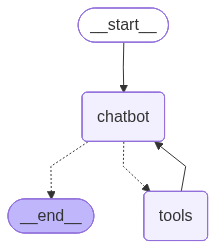

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


✅ Message sent successfully!
✅ Message sent successfully!


In [ ]:
all_tools = all_tools + tools

# Give context of the tools to the LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(all_tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)  

# Compile with memory
from langgraph.checkpoint.memory import MemorySaver
memory_saver = MemorySaver()
graph = graph_builder.compile(checkpointer=memory_saver)

display(Image(graph.get_graph().draw_mermaid_png()))

config = {"configurable": {"thread_id": "1"}}

# Use async chat function with ainvoke for proper async execution
async def chat(message, history):
    initial_state = State(messages=[{"role": "user", "content": message}])
    # Use ainvoke for async execution of Playwright tools
    result = await graph.ainvoke(initial_state, config=config)
    return result["messages"][-1].content

demo = gr.ChatInterface(chat, type="messages")
demo.launch()





